In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sns

# Pulling data from database to check that it was stored correctly and also to start analyzing it

In [6]:
conn = psycopg2.connect("host=localhost dbname=rancher")
df_sql = pd.read_sql_query("""SELECT * 
                              FROM cl_tutoring2
                              WHERE date_scraped = '2021-12-30'""", con=conn)

In [7]:
df_sql.tail()

,id,date_scraped,price,city,subregion,region,post_text,date_posted
427,859,2021-12-30,50.0,None,None,philadelphia,"\n\n\n\n\nTutoring rate. $50/hr, Group Rate, $...",2021-12-07 21:47:32
428,860,2021-12-30,90.0,Free 30-Min. Trial Lesson,Dallas,dallas,"""\n\n\n\n\nCall or Text Ash at (917) 359-9662 ...",2021-12-13 14:34:54
429,861,2021-12-30,25.0,None,Dallas,dallas,\n\n\n\n\n🖥 Learn Computer Programming! 🖥\nWit...,2021-12-20 14:15:33
430,862,2021-12-30,20.0,Worldwideweb,Dallas,dallas,"\n\n\n\n\nYes, you read right! I--Mr. C--am of...",2021-12-04 17:30:46
431,863,2021-12-30,22.5,San Antonio,None,san_antonio,"""\n\n\n\n\nAs a former student, I always looke...",2021-12-06 15:31:29


In [4]:
df_sql['region'].value_counts()

sf_bay_area     152
los_angeles     137
new_york         98
san_diego        62
sacramento       60
chicago          49
phoenix          36
dallas           26
houston          22
philadelphia     15
san_antonio      12
Name: region, dtype: int64

In [5]:
df_sql['subregion'].value_counts()

None                  90
Manhattan             64
San Francisco         54
Sf Valley             46
South Bay             45
City Of Chicago       41
City Of San Diego     35
East Bay              33
Central La            32
Westside-Southbay     30
Peninsula             28
North Sd County       27
Dallas                22
Queens                18
East Valley           17
Long Beach            16
San Gabriel Valley    13
North Bay             10
Central/South Phx     10
Phx North              9
North Chicagoland      8
Brooklyn               8
Fairfield              5
Fort Worth             2
New Jersey             2
Westchester            1
Santa Cruz             1
North Dfw              1
South Dfw              1
Name: subregion, dtype: int64

In [6]:
df_sql['price'].mean()

47.06477329347285

In [7]:
df_sql['price'].median()

45.0

In [8]:
df_sql.groupby(by='region')['price'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
region,,
chicago,53.438776,49
houston,51.295455,22
new_york,50.574830,98
los_angeles,49.083942,137
sf_bay_area,45.827851,152
dallas,45.557692,26
sacramento,45.277778,60
san_diego,44.024194,62
philadelphia,43.133333,15


In [9]:
df_sql[(df_sql['region']=='los_angeles') & (df_sql['price'] > 60)]['price']

60      65.0
75      70.0
76     120.0
77     100.0
78      80.0
87      70.0
90      70.0
93      70.0
273     65.0
284     70.0
285    120.0
286    100.0
291     70.0
292     80.0
298     70.0
398     65.0
406     70.0
407    120.0
412     70.0
414     80.0
416     70.0
507     65.0
514     70.0
515    120.0
518     70.0
522     80.0
524     70.0
614     65.0
623     70.0
624    120.0
627     70.0
629     80.0
632     70.0
Name: price, dtype: float64

TypeError: scatter() missing 1 required positional argument: 'y'

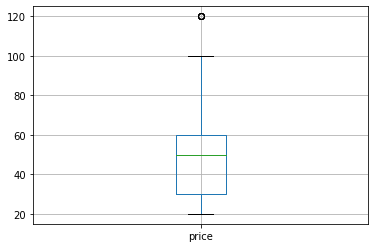

In [10]:
df_sql[df_sql['region']=='los_angeles'].boxplot(column='price')
plt.scatter(df_sql[df_sql['region']=='los_angeles']['price'])

In [ ]:
sns.boxplot(x='region', y='price', data=df_sql[df_sql['region']=='los_angeles'])
sns.swarmplot(x='region', y='price', data=df_sql[df_sql['region']=='los_angeles'], color='r');